# Analysis of Results
This notebook parses the study results in the responses folder and analyzes the results.

## Parsing

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'order'}>],
       [<Axes: title={'center': 'duration_log'}>, <Axes: >]], dtype=object)

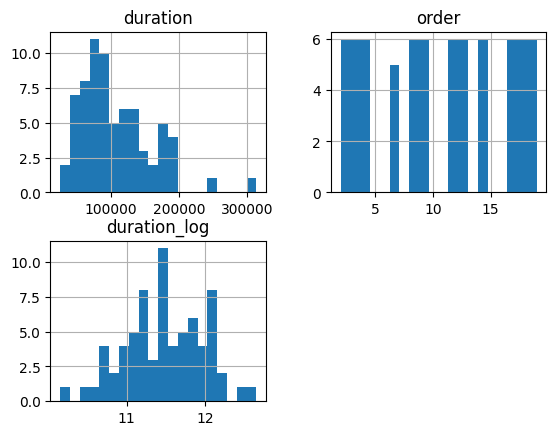

In [125]:
# load all files in data
# create a dataframe with all data

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import codecs

data = []
demo_surveys = ["-0"]
tutorial_surveys = ["-1", "-6", "-11", "-16"]
training_surveys = ["-2", "-7", "-12", "-17"]
tlx_surveys = ["-5", "-10", "-15", "-20"]
for filename in os.listdir("data"):
    #if not filename.startswith("44"):
    #    continue

    is_tutorial = any([tut + ".json" in filename for tut in tutorial_surveys])
    is_tlx = any([tlx + ".json" in filename for tlx in tlx_surveys])
    is_demo = any([demo + ".json" in filename for demo in demo_surveys])
    is_training = any([training + ".json" in filename for training in training_surveys])

    if not filename.endswith(".json"):
        continue

    if is_tutorial or is_demo:
        continue

    if is_tlx:
        continue
    
    with codecs.open(os.path.join("data", filename), "rb", encoding="utf_8", errors='ignore') as f:
        d = json.load(f)
        data.append([d["response"]["duration"], d["task"]["view"], d["response"]["stateId"], filename.split("-")[0]])

df = pd.DataFrame(data, columns=["duration", "view", "order", "id"])
# add a log transform to "duration" column of df
df['duration_log'] = np.log(df['duration'])
df.hist(bins=20)

we use duration_log because it is normally distributed, as required by e.g. ANOVA

### Indicate if you want to quantile normalize views over time

In [126]:
normalize = False

It is important to understand what's happening when quantile normalizing. What we do is to take all views and set their value to their average. If the data sets are equally distributed (balanced), the learning effect should be averaged out. This also removes any between-participant variance, which might be inapprobriate.

In [127]:
if normalize:
    for view in df["view"].unique():
        counts = df[df["view"] == view].value_counts("order", sort=False)  # order->count mapping
        # divide each duration by the number of times it appears in the view
        df["weighted_duration_log"] = df.loc[df["view"] == view, :].apply(lambda row: row["duration_log"] / counts[row["order"]], axis=1)
        # quantile normalize: (weighted) average of all with same view
        df.loc[df["view"] == view, "duration_log"] = df.loc[df["view"] == view, "weighted_duration_log"].sum() / counts.size

    print("As can be seen, all data points over all views are normalized to the same mean")
    df["duration_log"].hist(bins=50)

In [128]:
# group df by view
grouped = df.groupby("view")
grouped.describe()

duration                                                  \
                    count           mean           std      min       25%   
view                                                                        
Desktop-Decomp       17.0  111053.941176  56313.008692  35536.0  64784.00   
Desktop-NoDecomp     18.0  106430.055556  47277.105909  47297.0  67254.50   
VR-Decomp            18.0  114196.833333  70310.622848  25722.0  71537.75   
VR-NoDecomp          18.0  100897.000000  39495.327126  46577.0  73671.50   

                                                order             ...         \
                       50%        75%       max count       mean  ...    75%   
view                                                              ...          
Desktop-Decomp     92488.0  136223.00  246759.0  17.0   8.941176  ...  13.00   
Desktop-NoDecomp   96088.5  137585.75  197266.0  18.0   9.666667  ...  13.75   
VR-Decomp         100110.5  147640.50  313233.0  18.0  11.333333  ...  17.00   
VR-NoDecomp        91994.0  121002.50  185282.0  18.0  12.166667  ...  17.00   

                       duration_log                                  \
                   max        count       mean       std        min   
view                                                                  
Desktop-Decomp    19.0         17.0  11.489592  0.538196  10.478302   
Desktop-NoDecomp  19.0         18.0  11.481237  0.448824  10.764202   
VR-Decomp         19.0         18.0  11.469822  0.627963  10.155102   
VR-NoDecomp       19.0         18.0  11.453015  0.379615  10.748862   

                                                              
                        25%        50%        75%        max  
view                                                          
Desktop-Decomp    11.078814  11.434834  11.822049  12.416167  
Desktop-NoDecomp  11.116096  11.472983  11.831776  12.192308  
VR-Decomp         11.177980  11.513927  11.898694  12.654703  
VR-NoDecomp       11.207354  11.429466  11.703522  12.129634  

[4 rows x 24 columns]

In [129]:
grouped.get_group('Desktop-Decomp')

,duration,view,order,id,duration_log
2,53719,Desktop-Decomp,18,7,10.891522
10,149760,Desktop-Decomp,4,5,11.916789
13,90177,Desktop-Decomp,14,6,11.409530
16,87704,Desktop-Decomp,4,45,11.381723
17,43064,Desktop-Decomp,19,7,10.670443
21,167985,Desktop-Decomp,13,6,12.031630
23,64784,Desktop-Decomp,7,4,11.078814
26,136223,Desktop-Decomp,3,5,11.822049
28,123127,Desktop-Decomp,3,45,11.720972
30,246759,Desktop-Decomp,2,45,12.416167


In [130]:
# add column that is 0 if Desktop-Decomp or Desktop-NoDecomp, 1 if VR-Decomp or VR-NoDecomp
df["platform"] = df["view"].apply(lambda x: 1 if x.startswith("Desktop") else 2)
df["decomp"] = df["view"].apply(lambda x: 1 if x.endswith("NoDecomp") else 2)

In [131]:
# check how if every view is tested in every order -> we can try to normalize
df.groupby(["view", "order"]).describe()

duration                                                \
                          count      mean            std       min        25%   
view             order                                                          
Desktop-Decomp   2          2.0  189427.5   81078.984851  132096.0  160761.75   
                 3          2.0  129675.0    9260.270406  123127.0  126401.00   
                 4          2.0  118732.0   43880.218413   87704.0  103218.00   
                 7          1.0   64784.0            NaN   64784.0   64784.00   
                 8          2.0   94832.0   54000.330666   56648.0   75740.00   
                 9          2.0  138535.5   65120.999013   92488.0  115511.75   
                 12         1.0   90248.0            NaN   90248.0   90248.00   
                 13         1.0  167985.0            NaN  167985.0  167985.00   
                 14         1.0   90177.0            NaN   90177.0   90177.00   
                 17         1.0   35536.0            NaN   35536.0   35536.00   
                 18         1.0   53719.0            NaN   53719.0   53719.00   
                 19         1.0   43064.0            NaN   43064.0   43064.00   
Desktop-NoDecomp 2          2.0  145960.0   48773.397339  111472.0  128716.00   
                 3          2.0  166004.5    5933.333001  161809.0  163906.75   
                 4          2.0  125889.0  100942.321442   54512.0   90200.50   
                 7          1.0   61783.0            NaN   61783.0   61783.00   
                 8          1.0   55937.0            NaN   55937.0   55937.00   
                 9          1.0   47297.0            NaN   47297.0   47297.00   
                 12         2.0  113879.5   26405.488530   95208.0  104543.75   
                 13         2.0   67916.0    1871.004543   66593.0   67254.50   
                 14         2.0   87324.5   13639.382702   77680.0   82502.25   
                 17         1.0   83216.0            NaN   83216.0   83216.00   
                 18         1.0  139264.0            NaN  139264.0  139264.00   
                 19         1.0  114297.0            NaN  114297.0  114297.00   
VR-Decomp        2          1.0  178250.0            NaN  178250.0  178250.00   
                 3          1.0  125547.0            NaN  125547.0  125547.00   
                 4          1.0  154848.0            NaN  154848.0  154848.00   
                 7          2.0  142271.5   45535.555388  110073.0  126172.25   
                 8          2.0  201977.5  157339.036989   90722.0  146349.75   
                 9          2.0   98857.0   38411.454568   71696.0   85276.50   
                 12         1.0   42301.0            NaN   42301.0   42301.00   
                 13         1.0   25722.0            NaN   25722.0   25722.00   
                 14         1.0   45029.0            NaN   45029.0   45029.00   
                 17         2.0  149464.5   67764.164161  101548.0  125506.25   
                 18         2.0   60102.5   16097.285874   48720.0   54411.25   
                 19         2.0   89250.0   13326.134398   79827.0   84538.50   
VR-NoDecomp      2          1.0   93730.0            NaN   93730.0   93730.00   
                 3          1.0   46577.0            NaN   46577.0   46577.00   
                 4          1.0   74798.0            NaN   74798.0   74798.00   
                 7          1.0  109039.0            NaN  109039.0  109039.00   
                 8          1.0   92450.0            NaN   92450.0   92450.00   
                 9          1.0  172180.0            NaN  172180.0  172180.00   
                 12         2.0   96395.5   54586.522187   57797.0   77096.25   
                 13         2.0  129855.5   78384.908015   74429.0  102142.25   
                 14         2.0  112882.5   56238.323628   73116.0   92999.25   
                 17         2.0   83228.0   11752.114703   74918.0   79073.00   
                 18         2.0   93784.5   35698.2858

# we learn a linear regression to check the influence of order

In [132]:
# linear regression for duration ~ platform + decomp
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("duration_log ~ order", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           duration_log   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     8.519
Date:                Mon, 28 Aug 2023   Prob (F-statistic):            0.00474
Time:                        18:54:41   Log-Likelihood:                -46.334
No. Observations:                  71   AIC:                             96.67
Df Residuals:                      69   BIC:                             101.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7768      0.118     99.711      0.0

### one alternative to normalizing would be detrending, where we adjust for the order effect learned before in the regression model

make sure that normalize = False before setting  detrend = True

In [133]:
detrend = False
if detrend and not normalize:
    df["duration_log"] = df["duration_log"] - model.predict(df["order"])

{'whiskers': [<matplotlib.lines.Line2D at 0x29aadd1e0>,
 'caps': [<matplotlib.lines.Line2D at 0x29aadd630>,
 'boxes': [<matplotlib.lines.Line2D at 0x29aadc190>,
 'medians': [<matplotlib.lines.Line2D at 0x29aaddb70>,
 'fliers': [<matplotlib.lines.Line2D at 0x29aade6b0>,
 'means': []}

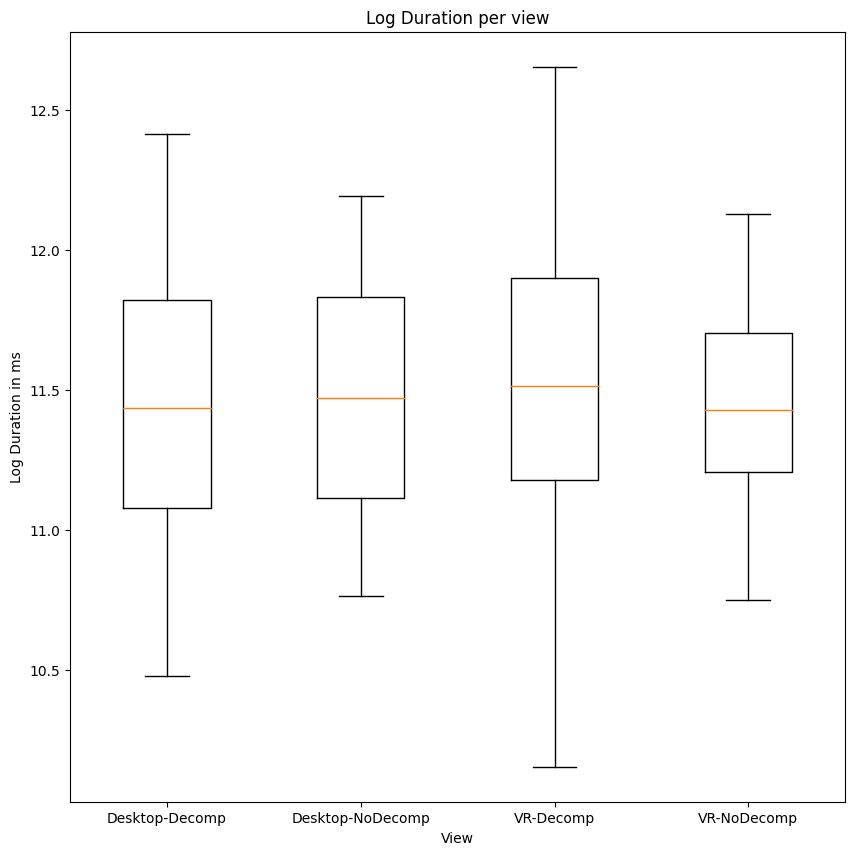

In [134]:
# boxplot for duration
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Log Duration per view")
ax.set_ylabel("Log Duration in ms")
ax.set_xlabel("View")   
ax.boxplot([grouped.get_group(view)["duration_log"].values for view in grouped.groups.keys()], labels=grouped.groups.keys(), bootstrap=10000)

Text(0, 0.5, 'Log Duration, log_10(s)')

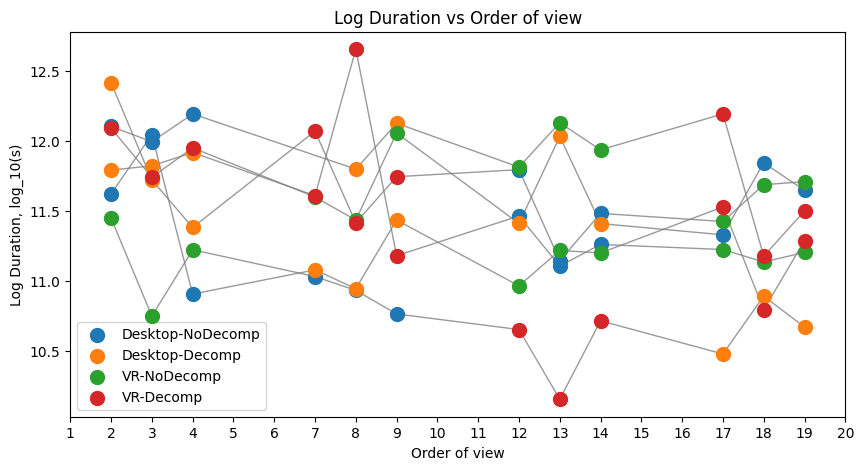

In [135]:
# draw scatter plot of log_duration vs order column of df
fig, ax = plt.subplots(figsize=(10, 5))

for id in df['id'].unique():
    df_id = df[df['id'] == id]
    df_id = df_id.sort_values(by=['order'])
    ax.plot(df_id['order'], df_id['duration_log'], alpha=0.8, color='grey', linewidth=1)

for view in df['view'].unique():
    df_view = df[df['view'] == view]
    ax.scatter(df_view['order'], df_view['duration_log'], alpha=1, label=view, s=100, zorder=10)

# set x ticks as integers

ax.set_xticks(np.arange(1, 21, 1))

ax.legend()
ax.set_title("Log Duration vs Order of view")
ax.set_xlabel('Order of view')
ax.set_ylabel('Log Duration, log_10(s)')

In [136]:
df.groupby(by=["id", "view"]).describe()

duration                                          \
                       count           mean            std       min   
id view                                                                
4  Desktop-Decomp        3.0   71306.666667   18789.233229   56648.0   
   Desktop-NoDecomp      3.0  112061.333333   57846.251575   54512.0   
   VR-Decomp             3.0   76698.333333   26552.604624   48720.0   
   VR-NoDecomp           3.0   68447.333333    9246.793624   57797.0   
44 Desktop-Decomp        2.0  158799.500000   36463.375385  133016.0   
   Desktop-NoDecomp      3.0  179841.000000   17736.291862  161809.0   
   VR-Decomp             3.0  122513.000000   66247.338845   71485.0   
   VR-NoDecomp           3.0  157641.666667   25513.051098  134994.0   
45 Desktop-Decomp        3.0  152530.000000   83504.643961   87704.0   
   Desktop-NoDecomp      3.0   99586.333333   31737.047143   69239.0   
   VR-Decomp             3.0  130403.333333   42045.870634   90722.0   
   VR-NoDecomp           3.0  110742.000000   16683.216147   91538.0   
5  Desktop-Decomp        3.0  139359.666667    9240.304775  132096.0   
   Desktop-NoDecomp      3.0   79827.000000   14427.812135   66593.0   
   VR-Decomp             3.0  165000.666667  129799.141046   71696.0   
   VR-NoDecomp           3.0   72293.000000    3333.804283   68542.0   
6  Desktop-Decomp        3.0  116136.666667   44901.987844   90177.0   
   Desktop-NoDecomp      3.0  112259.000000   28079.523839   83216.0   
   VR-Decomp             3.0  152881.666667   26406.465162  125547.0   
   VR-NoDecomp           3.0  124556.333333   42069.097332   92450.0   
7  Desktop-Decomp        3.0   44106.333333    9136.203606   35536.0   
   Desktop-NoDecomp      3.0   55005.666667    7287.769572   47297.0   
   VR-Decomp             3.0   37684.000000   10448.807540   25722.0   
   VR-NoDecomp           3.0   71701.666667   23728.502109   46577.0   

                                                              order        \
                           25%       50%        75%       max count  mean   
id view                                                                     
4  Desktop-Decomp     60716.00   64784.0   78636.00   92488.0   3.0   8.0   
   Desktop-NoDecomp   82992.00  111472.0  140836.00  170200.0   3.0   3.0   
   VR-Decomp          64273.50   79827.0   90687.50  101548.0   3.0  18.0   
   VR-NoDecomp        65456.50   73116.0   73772.50   74429.0   3.0  13.0   
44 Desktop-Decomp    145907.75  158799.5  171691.25  184583.0   2.0   8.5   
   Desktop-NoDecomp  171128.50  180448.0  188857.00  197266.0   3.0   3.0   
   VR-Decomp          85079.00   98673.0  148027.00  197381.0   3.0  18.0   
   VR-NoDecomp       143821.50  152649.0  168965.50  185282.0   3.0  13.0   
45 Desktop-Decomp    105415.50  123127.0  184943.00  246759.0   3.0   3.0   
   Desktop-NoDecomp   83104.00   96969.0  114760.00  132551.0   3.0  13.0   
   VR-Decomp         108370.00  126018.0  150244.00  174470.0   3.0   8.0   
   VR-NoDecomp       105282.50  119027.0  120344.00  121661.0   3.0  18.0   
5  Desktop-Decomp    134159.50  136223.0  142991.50  149760.0   3.0   3.0   
   Desktop-NoDecomp   72136.50   77680.0   86444.00   95208.0   3.0  13.0   
   VR-Decomp          90884.50  110073.0  211653.00  313233.0   3.0   8.0   
   VR-NoDecomp        70980.50   73419.0   74168.50   74918.0   3.0  18.0   
6  Desktop-Decomp     90212.50   90248.0  129116.50  167985.0   3.0  13.0   
   Desktop-NoDecomp   98756.50  114297.0  126780.50  139264.0   3.0  18.0   
   VR-Decomp         140197.50  154848.0  166549.00  178250.0   3.0   3.0   
   VR-NoDecomp       100744.50  109039.0  140609.50  172180.0   3.0   8.0   
7  Desktop-Decomp     39300.00   43064.0   48391.50   53719.0   3.0  18.0   
   Desktop-NoDecomp   51617.00   55937.0   58860.00   61783.0   3.0   8.0   
   VR-Decomp          34011.50   42301.0   43665.00   45029.0   3.0  13.0   
   VR-NoDecomp        60687.50   74798.0   84264.00   93730.0   3.0   3.0

## TLX

,tlxsum,view,order,id
0,267,Desktop-Decomp,1,45
1,175,Desktop-Decomp,3,6
2,214,VR-Decomp,4,44
3,287,Desktop-Decomp,1,5
4,246,VR-Decomp,3,7
5,259,VR-NoDecomp,4,45
6,251,VR-NoDecomp,1,7
7,107,Desktop-NoDecomp,3,5
8,351,Desktop-Decomp,2,44
9,212,VR-Decomp,2,45


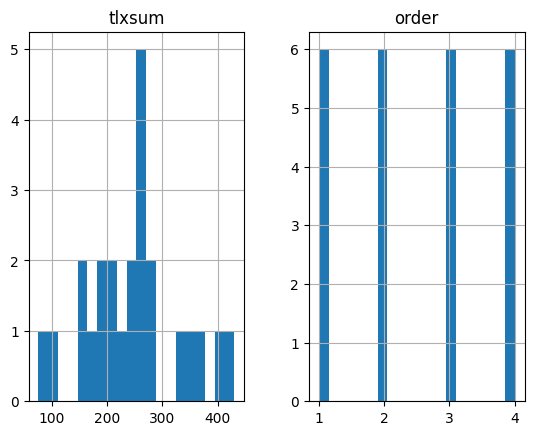

In [137]:
# load all files in data
# create a dataframe with all data

import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import codecs

data = []
demo_surveys = ["-0"]
tutorial_surveys = ["-1", "-6", "-11", "-16"]
tlx_surveys = ["-5", "-10", "-15", "-20"]
for filename in os.listdir("data"):
    #if not filename.startswith("44"):
    #    continue

    is_tutorial = any([tut + ".json" in filename for tut in tutorial_surveys])
    is_tlx = any([tlx + ".json" in filename for tlx in tlx_surveys])
    is_demo = any([demo + ".json" in filename for demo in demo_surveys])

    if not filename.endswith(".json"):
        continue

    if is_tutorial or is_demo:
        continue

    if not is_tlx:
        continue
    
    # is tlx:
    with codecs.open(os.path.join("data", filename), "rb", encoding="utf_8", errors='ignore') as f:
        d = json.load(f)
        i = d["task"]["stateId"] - 1
        d["response"]["view"] = d["task"]["_views"][i]
        data.append([sum(d["response"]["scores"]["scores"]), d["response"]["view"], int(d["response"]["stateId"] / 5), filename.split("-")[0]])

df = pd.DataFrame(data, columns=["tlxsum", "view", "order", "id"])
df.hist(bins=20)
df

### again: normalization

In [138]:
normalize = False
if normalize:
    for view in df["view"].unique():
        counts = df[df["view"] == view].value_counts("order", sort=False)  # order->count mapping
        # divide each duration by the number of times it appears in the view
        df["weighted_tlxsum"] = df.loc[df["view"] == view, :].apply(lambda row: row["tlxsum"] / counts[row["order"]], axis=1)
        # quantile normalize: (weighted) average of all with same view
        df.loc[df["view"] == view, "tlxsum"] = df.loc[df["view"] == view, "weighted_tlxsum"].sum() / counts.size

    print("As can be seen, all data points over all views are normalized to the same mean")
    df["tlxsum"].hist(bins=50)

In [139]:
# group df by view
grouped = df.groupby("view")
grouped.describe()

tlxsum                                                       \
                  count        mean         std    min     25%    50%    75%   
view                                                                           
Desktop-Decomp      6.0  252.666667   76.172611  149.0  198.00  277.0  287.0   
Desktop-NoDecomp    6.0  263.166667  110.211463  107.0  212.50  258.0  311.0   
VR-Decomp           6.0  230.500000   72.207340  157.0  194.75  213.0  238.0   
VR-NoDecomp         6.0  245.000000  101.821412   76.0  233.75  255.0  260.5   

                        order                                                 
                    max count      mean       std  min   25%  50%   75%  max  
view                                                                          
Desktop-Decomp    351.0   6.0  2.166667  1.169045  1.0  1.25  2.0  2.75  4.0  
Desktop-NoDecomp  430.0   6.0  2.333333  1.211060  1.0  1.25  2.5  3.00  4.0  
VR-Decomp         365.0   6.0  2.666667  1.211060  1.0  2.00  2.5  3.75  4.0  
VR-NoDecomp       395.0   6.0  2.833333  1.169045  1.0  2.25  3.0  3.75  4.0

In [140]:
# add column that is 0 if Desktop-Decomp or Desktop-NoDecomp, 1 if VR-Decomp or VR-NoDecomp
df["platform"] = df["view"].apply(lambda x: 0 if x.startswith("Desktop") else 1)
df["decomp"] = df["view"].apply(lambda x: 0 if x.endswith("NoDecomp") else 1)

In [141]:
detrend = False
if detrend and not normalize:
    model = ols("tlxsum ~ order", data=df).fit()
    df["tlxsum"] = df["tlxsum"] - model.predict(df["order"])

Text(0, 0.5, 'TLX sum')

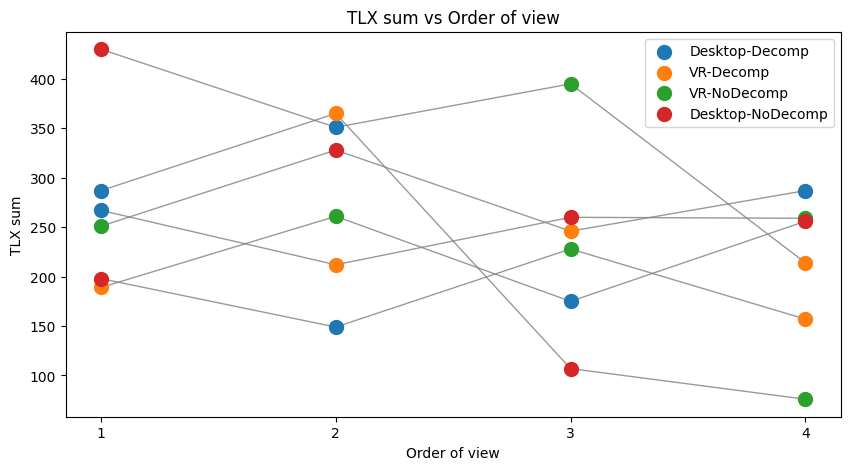

In [142]:
# draw scatter plot of log_duration vs order column of df
fig, ax = plt.subplots(figsize=(10, 5))

for id in df['id'].unique():
    df_id = df[df['id'] == id]
    df_id = df_id.sort_values(by=['order'])
    ax.plot(df_id['order'], df_id['tlxsum'], alpha=0.8, color='grey', linewidth=1)

for view in df['view'].unique():
    df_view = df[df['view'] == view]
    ax.scatter(df_view['order'], df_view['tlxsum'], alpha=1, label=view, s=100, zorder=10)

# set x ticks as integers

ax.set_xticks(np.arange(1, 5, 1))

ax.legend()
ax.set_title("TLX sum vs Order of view")
ax.set_xlabel('Order of view')
ax.set_ylabel('TLX sum')

{'whiskers': [<matplotlib.lines.Line2D at 0x29ae19f90>,
 'caps': [<matplotlib.lines.Line2D at 0x29ae1a4d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x29ae19d50>,
 'medians': [<matplotlib.lines.Line2D at 0x29ae1aa10>,
 'fliers': [<matplotlib.lines.Line2D at 0x29ae1acb0>,
 'means': []}

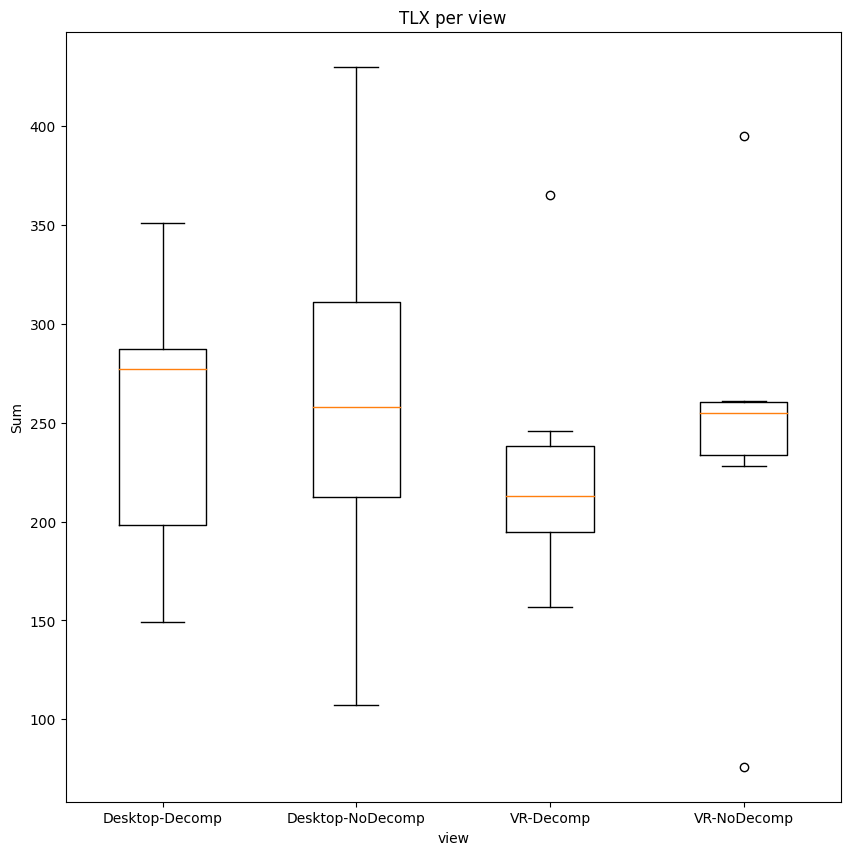

In [143]:
# boxplot for duration
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("TLX per view")
ax.set_ylabel("Sum")
ax.set_xlabel("view")
ax.boxplot([grouped.get_group(view)["tlxsum"].values for view in grouped.groups.keys()], labels=grouped.groups.keys(), bootstrap=10000)